In [1]:
# Vamos a utilizar las redes neuronales pero esta vez convolucionales para realizarlo de forma avanzada
# Nos basamos en un dataset de numeros escritos a mano

2023-12-08 11:33:49.451315: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-08 11:33:49.451383: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


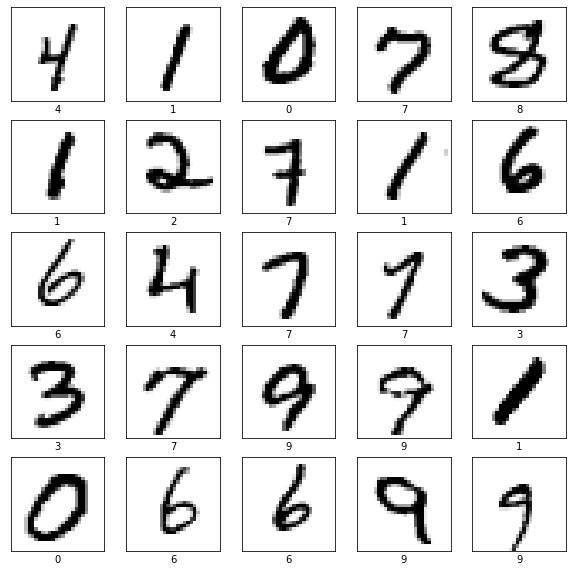

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


# Descargamos el set de datos de MNIST (Números escritos a mano, etiquetados)
datos, metadatos = tfds.load('mnist', as_supervised = True, with_info = True)

# Obtenemos en variable separadas los datos de entrenamiento (60k) y pruebas (10k)
datos_entrenamiento, datos_pruebas= datos['train'], datos['test']

# Realizamos la funcion de normalizacion para normalizar todos los valores (Pasar el valor de px a 0-255)
# Con esto hacemos que la red aprenda mejor y más rapido

def normalizar(imagenes, etiquetas):
    imagenes = tf.cast(imagenes, tf.float32)
    imagenes /= 255
    return imagenes, etiquetas

# Normalizamos los datos de entrenamiento con la función que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

# Agregamos a cache (usamos memoria en vez de disco, entrenamiento mas rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

clases = ['0','1','2','3','4','5','6','7','8','9']

plt.figure(figsize=(10,10))

for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
    imagen = imagen.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imagen,cmap=plt.cm.binary)
    plt.xlabel(clases[etiqueta])
    
plt.show()

In [7]:
# Creamos el modelo (Modelo dennso, regular, sin redes convolucionales todavia)

# Modelo regular
#modelo = tf.keras.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28,28,1)), # 28 px x 28 y el 1 es para un solo canal al ser B&N
#   tf.keras.layers.Dense(units=50, activation='relu'),
#   tf.keras.layers.Dense(units=50, activation='relu'),
#

# Modelo convolucional, hay dos funciones más para hacer la red mas robusta (aumento de datos y dropout)
modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape= (28,28,1), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), # 2,2 es el tamaño de la matriz
    
    tf.keras.layers.Conv2D(64,(3,3), input_shape= (28,28,1), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), # 2,2 es el tamaño de la matriz
    
    # Dropout, se utiliza para que no haya descompensacion en los pesos de las redes, las neuronas se apagan aleatoreamente y se pongan a trabajar
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')
    
])

# Compilamos el modelo
modelo.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [8]:
# Los numeros de datos de entrenamiento y pruebas (60k y 10k)
num_datos_entrenamiento = metadatos.splits["train"].num_examples
num_datos_pruebas = metadatos.splits["test"].num_examples

# Trabajar por lotes
TAMANO_LOTE = 32

# Shuffle y repeat hacen que los datos estén mezclados de manera aleatoria
# para que el entrenamiento no se aprenda las cosas en orden
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_datos_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [ ]:
# Realizamos el entrenamiento por 60 epocas
import math

historial = modelo.fit(
    datos_entrenamiento,
    epochs=5,
    steps_per_epoch=math.ceil(num_datos_entrenamiento/TAMANO_LOTE)
)

Epoch 1/5
1701/1875 [==========================>...] - ETA: 2s - loss: 0.1761 - accuracy: 0.9448

In [ ]:
# Exportamos el modelo al explorador
modelo.save('numeros.h5')

# Convertirmos a tensorflow.js
!pip install tensorflowjs

!mkdir carpeta_salida1

!tensorflowjs_converter --input_format keras numeros.h5 carpeta_salida1